<a href="https://colab.research.google.com/github/jasonjstewart/college-football/blob/master/College_Football_4th_Down_SuccessfulorNot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd
 import seaborn as sns
 import matplotlib.pyplot as plt
 import numpy as np
 
 df = pd.read_csv('https://jasonstewart.s3.amazonaws.com/LogReg+Final+CSV.csv')

df.drop(['yards_gained', 'ppa','Unnamed: 0'], axis=1, inplace=True)
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,home,offense_score,defense_score,period,clock,yard_line,yards_to_goal,distance,plays,yards,season,week,success_or_failure
0,0,0,7,1,89,36,36,4,12,64,2015,11,0
1,1,0,0,1,696,68,32,2,6,19,2018,5,0
2,0,3,7,1,315,56,56,2,5,19,2015,6,0
3,1,14,14,2,562,65,35,11,8,25,2014,4,0
4,1,0,3,1,482,47,53,1,11,74,2014,4,0


In [ ]:
df['offense_scoreCR'] = np.cbrt(df['offense_score'])

df['defense_scoreSR'] = np.sqrt(df['defense_score'])

df['distanceCR'] = np.cbrt(df['distance'])



df.head()
df.skew()

home                 -0.259158
offense_score         1.050551
defense_score         0.607788
period               -0.485519
clock                 0.259325
yard_line            -0.082750
yards_to_goal         0.362209
distance              1.953465
plays                 0.470479
yards                -0.251663
season                0.016809
week                 -0.044381
success_or_failure    0.466151
offense_scoreCR      -0.892637
defense_scoreSR      -0.411062
distanceCR            0.466426
dtype: float64

In [ ]:
##Take out offense_score, defense_score, distance, yards_gained, excitement_index
##and replace with a CR or SR with a better skewness score

df.drop(['offense_score','defense_score','distance'], axis=1, inplace=True)
df.skew()

home                 -0.259158
period               -0.485519
clock                 0.259325
yard_line            -0.082750
yards_to_goal         0.362209
plays                 0.470479
yards                -0.251663
season                0.016809
week                 -0.044381
success_or_failure    0.466151
offense_scoreCR      -0.892637
defense_scoreSR      -0.411062
distanceCR            0.466426
dtype: float64

In [ ]:
#CORRECT OUTLIERS, this first part checks to see if there are outliers
outliers = pd.DataFrame(columns=['min', 'count below', 'max', 'count above'])

# save the max to compare later
# peak_max = df[''].mean() + (df[''].std() * 3)

# Loop through each column in the dataframe except those that are: 1) categorical, 2) empty, or 3) binary (0/1)
for col in df:
  if pd.api.types.is_numeric_dtype(df[col]) and (len(df[col].value_counts()) > 0) and not all(df[col].value_counts().index.isin([0, 1])):
    # Calculate the theoretical min/max
    min = int(df[col].mean() - (df[col].std() * 3))
    max = int(df[col].mean() + (df[col].std() * 3))
    outliers.loc[col] = (min, df[col][df[col] < min].count(), max, df[col][df[col] > max].count())

outliers

#Goes through each column in DF to replace outliers with min or max
def manage_outliers(df):
  for col in df:
    if pd.api.types.is_numeric_dtype(df[col]) and (len(df[col].value_counts()) > 0) and not all(df[col].value_counts().index.isin([0, 1])):
      min = df[col].mean() - (df[col].std() * 3)
      max = df[col].mean() + (df[col].std() * 3)

      # Once the min/max is calculated for a column, take an inner loop through the row values of each column to replace values
      for i, value in enumerate(df[col]): 
        if value < min:      
          df.at[i, col + '_3std'] = min  # replace with min
          df.at[i, 'outlier'] = 1         # identify the record as an outlier for future filtering
        elif value > max:    
          df.at[i, col + '_3std'] = max   # replace with max
          df.at[i, 'outlier'] = 1
        else:                
          df.at[i, col + '_3std'] = value # use original value
          df.at[i, 'outlier'] = 0
    
  # I don't like binary variables like "outlier" becoming floats; cast it back to an int
  # if 'outlier' in df.columns:
  #   df = df.astype({"outlier": int})

  # View the cleaned dataset:
  print(df.head())

In [ ]:
print(df.isnull().sum())        # Gives you the missing values for each column
print(df.isnull().sum().sum())  # Gives you the missing values for the whole 

home                  0
period                0
clock                 0
yard_line             0
yards_to_goal         0
plays                 0
yards                 0
season                0
week                  0
success_or_failure    0
offense_scoreCR       0
defense_scoreSR       0
distanceCR            0
dtype: int64
0


In [ ]:
def mlr_prepare(df):
  import numpy as np
  import pandas as pd
  from sklearn import preprocessing

  for col in df:
    if not pd.api.types.is_numeric_dtype(df[col]):
      print(col)
      df = df.join(pd.get_dummies(df[col], prefix=col, drop_first=False))
      df.drop([col], axis=1, inplace=True)

  return df
df = mlr_prepare(df)
df

,home,period,clock,yard_line,yards_to_goal,plays,yards,season,week,success_or_failure,offense_scoreCR,defense_scoreSR,distanceCR
0,0,1,89,36,36,12,64,2015,11,0,0.000000,2.645751,1.587401
1,1,1,696,68,32,6,19,2018,5,0,0.000000,0.000000,1.259921
2,0,1,315,56,56,5,19,2015,6,0,1.442250,2.645751,1.259921
3,1,2,562,65,35,8,25,2014,4,0,2.410142,3.741657,2.223980
4,1,1,482,47,53,11,74,2014,4,0,0.000000,1.732051,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9358,1,1,474,76,24,16,63,2014,2,1,0.000000,0.000000,1.259921
9359,1,2,900,92,8,13,64,2014,13,1,0.000000,2.645751,1.259921
9360,1,2,528,91,9,11,83,2014,12,1,2.410142,2.645751,1.000000
9361,1,1,73,71,29,17,41,2014,14,1,0.000000,2.645751,1.000000


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

label = "success_or_failure"

# Set label and features
y = df[label]                    
X = df.select_dtypes(np.number).assign(const=1)
X = X.drop(columns=[label])

# Run the multiple linear regression model
model = sm.OLS(y, X)
results = model.fit()

# View results
print(df.skew())
print(results.summary())

home                 -0.259158
period               -0.485519
clock                 0.259325
yard_line            -0.082750
yards_to_goal         0.362209
plays                 0.470479
yards                -0.251663
season                0.016809
week                 -0.044381
success_or_failure    0.466151
offense_scoreCR      -0.892637
defense_scoreSR      -0.411062
distanceCR            0.466426
dtype: float64
                            OLS Regression Results                            
Dep. Variable:     success_or_failure   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     463.2
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        03:32:39   Log-Likelihood:                -4363.8
No. Observations:                9363   AIC:                             8754.
Df Residuals:                

,home,period,clock,yard_line,yards_to_goal,plays,yards,season,week,success_or_failure,offense_scoreCR,defense_scoreSR,distanceCR
home,1.000000,-0.046378,0.047941,0.591543,-0.030134,0.022047,0.029882,-0.000373,-0.095197,0.058390,0.084960,-0.171464,-0.059331
period,-0.046378,1.000000,-0.122219,-0.023965,0.058480,-0.025723,-0.113206,-0.024951,0.021207,-0.161053,0.587542,0.659803,0.243817
clock,0.047941,-0.122219,1.000000,0.021086,-0.080863,0.084634,0.129587,0.081095,-0.019907,0.100072,-0.196112,-0.220926,-0.201383
yard_line,0.591543,-0.023965,0.021086,1.000000,-0.111917,0.017870,0.024735,-0.014677,-0.083586,0.045401,0.065360,-0.124413,-0.063156
yards_to_goal,-0.030134,0.058480,-0.080863,-0.111917,1.000000,-0.241319,-0.335000,-0.006421,0.017507,-0.188275,-0.056009,0.112815,0.267549
plays,0.022047,-0.025723,0.084634,0.017870,-0.241319,1.000000,0.696129,0.083333,0.008861,0.348470,-0.046350,0.002533,-0.140624
yards,0.029882,-0.113206,0.129587,0.024735,-0.335000,0.696129,1.000000,0.084553,0.000329,0.577312,-0.034211,-0.062625,-0.266529
season,-0.000373,-0.024951,0.081095,-0.014677,-0.006421,0.083333,0.084553,1.000000,0.015100,0.072601,0.009568,0.021106,-0.030861
week,-0.095197,0.021207,-0.019907,-0.083586,0.017507,0.008861,0.000329,0.015100,1.000000,-0.033821,-0.057554,0.120333,0.040298
success_or_failure,0.058390,-0.161053,0.100072,0.045401,-0.188275,0.348470,0.577312,0.072601,-0.033821,1.000000,0.022896,-0.162175,-0.257938


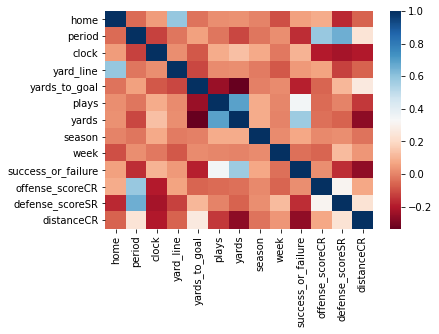

In [ ]:
##Checking for Multicollinearity
corr = df.corr()
display(corr)

##Plot a heatm
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = "RdBu")


In [ ]:

x_vars = df.drop(columns = ['success_or_failure'])

y_vars = df.success_or_failure

In [ ]:
# Import this function
from sklearn.model_selection import train_test_split

# Create partitions
x_train, x_valid, y_train, y_valid = train_test_split(x_vars,y_vars, test_size=0.4, random_state=1)

In [ ]:
print('x_train contains:',len(x_train) ,'rows')
print('y_train contains:',len(y_train) ,'rows')
print(' x_valid contains:',len(x_valid) ,'rows')
print(' y_valid contains:',len(y_valid) ,'rows')


x_train contains: 5617 rows
y_train contains: 5617 rows
 x_valid contains: 3746 rows
 y_valid contains: 3746 rows


In [ ]:
x_train = x_train.sort_index()
y_train = y_train.sort_index()
x_valid = x_valid.sort_index()
y_valid = y_valid.sort_index()
x_train

,home,period,clock,yard_line,yards_to_goal,plays,yards,season,week,offense_scoreCR,defense_scoreSR,distanceCR
0,0,1,89,36,36,12,64,2015,11,0.000000,2.645751,1.587401
1,1,1,696,68,32,6,19,2018,5,0.000000,0.000000,1.259921
2,0,1,315,56,56,5,19,2015,6,1.442250,2.645751,1.259921
5,0,1,900,35,35,7,44,2018,6,0.000000,0.000000,2.080084
8,0,2,900,2,2,12,64,2015,11,0.000000,2.645751,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
9355,0,2,715,43,43,8,47,2019,14,0.000000,1.732051,1.442250
9358,1,1,474,76,24,16,63,2014,2,0.000000,0.000000,1.259921
9360,1,2,528,91,9,11,83,2014,12,2.410142,2.645751,1.000000
9361,1,1,73,71,29,17,41,2014,14,0.000000,2.645751,1.000000


In [ ]:
# Now the partitions are ready, lets get ready to train the model

# Get  linear regression method from library
from sklearn.linear_model import LinearRegression

# Create multiple linear regression object
mlr = LinearRegression()

## step 2: fit (train) the linear model with the training data)

mlr.fit(x_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print("Intercept: {0:.3f} ".format(mlr.intercept_))

coeff_df = pd.DataFrame(mlr.coef_, x_train.columns, columns=['Coefficient'])
coeff_df

Intercept: -4.721 


,Coefficient
home,-0.008772
period,-0.037182
clock,0.000009
yard_line,0.000406
yards_to_goal,0.001103
plays,-0.010790
yards,0.011064
season,0.002408
week,-0.001171
offense_scoreCR,0.057236


In [ ]:
# The model is trained. But the Linear Regression Model from the sklearn library
# does not included the ability to conveniently show the p-value of the 
# regression coefficients. Fortunately, the statsmodel library does this easily: 

# Get the P-Value of the coefficients
X2 = sm.add_constant(x_train)
est = sm.OLS(y, X.astype(float)).fit()
##est2 = est.fit()
print(est.summary())
#print(round(est2.pvalues.astype('float'),3))

                            OLS Regression Results                            
Dep. Variable:     success_or_failure   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     463.2
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        03:32:59   Log-Likelihood:                -4363.8
No. Observations:                9363   AIC:                             8754.
Df Residuals:                    9350   BIC:                             8846.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
home                0.0021      0.010     

In [ ]:
y_pred = mlr.predict(x_valid)  
y_pred

array([0.16736812, 0.73650876, 0.26798611, ..., 0.56833513, 0.7633894 ,
       0.48753807])

In [ ]:
## Create a dataframe to display the results of the actual and the predicted values

df = pd.DataFrame({'Actual': y_valid, 'Predicted': y_pred})  
df.to_csv('results.csv')

## The actual and predicted values are pretty close for most records.

In [ ]:
# To check for the quality of our regression, use model quality metrics. 
# These metrics are calculated by comparing y_test (actual) and y_test (predicted).
import sklearn

R2 = sklearn.metrics.r2_score(y_valid, y_pred)
MAE = sklearn.metrics.mean_absolute_error(y_valid, y_pred)
RMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_valid, y_pred))

print("R2: {0:.3f} ".format(R2))
print("MAE: {0:.1f} ".format(MAE))
print("RMSE: {0:.1f} ".format(RMSE))



R2: 0.381 
MAE: 0.3 
RMSE: 0.4 
